"""IMPROVED CHEST X-RAY DISEASE CLASSIFICATION - OPTIMIZED FOR SICK DETECTION

Key improvements for better sick detection:
1. Lower classification threshold (0.3 instead of 0.4)
2. Higher boost factor for class weights (5x instead of 3x)
3. Stronger augmentation to learn disease patterns better
4. Test-Time Augmentation (TTA) for more robust predictions
5. Ensemble predictions for critical cases
6. Focus on minimizing False Negatives (missing sick people)
"""

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import json

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
from PIL import Image

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    roc_auc_score,
    roc_curve,
    auc,
    f1_score,
    precision_score,
    recall_score,
    confusion_matrix,
    accuracy_score
)

In [2]:
torch.manual_seed(42)
np.random.seed(42)

print(f"PyTorch Version: {torch.__version__}")
print(f"Torchvision Version: {torchvision.__version__}")
print(f"CUDA Available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

PyTorch Version: 2.8.0+cu126
Torchvision Version: 0.23.0+cu126
CUDA Available: True
GPU: Tesla T4


In [3]:
from google.colab import files

print("📁 Please upload your kaggle.json file:")
uploaded = files.upload()

# Setup Kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

print("\n📥 Downloading NIH Chest X-ray Dataset (this may take 5-10 minutes)...")
!kaggle datasets download -d nih-chest-xrays/sample
!unzip -q sample.zip -d chest_xray_data

print("✅ Dataset downloaded!")

# Paths
DATA_DIR = "chest_xray_data/sample/images"
LABELS_FILE = "chest_xray_data/sample_labels.csv"

📁 Please upload your kaggle.json file:


Saving kaggle.json to kaggle.json

📥 Downloading NIH Chest X-ray Dataset (this may take 5-10 minutes)...
Dataset URL: https://www.kaggle.com/datasets/nih-chest-xrays/sample
License(s): CC0-1.0
100% 4.19G/4.20G [00:43<00:00, 264MB/s]
100% 4.20G/4.20G [00:43<00:00, 104MB/s]
✅ Dataset downloaded!



📊 Dataset Overview:
Total images: 5606
Total patients: 4230

💊 Disease Distribution:
Infiltration          967
Effusion              644
Atelectasis           508
Nodule                313
Mass                  284
Pneumothorax          271
Consolidation         226
Cardiomegaly          141
Emphysema             127
Edema                 118
Fibrosis               84
Pneumonia              62
Hernia                 13
Pleural_thickening      0
dtype: int64


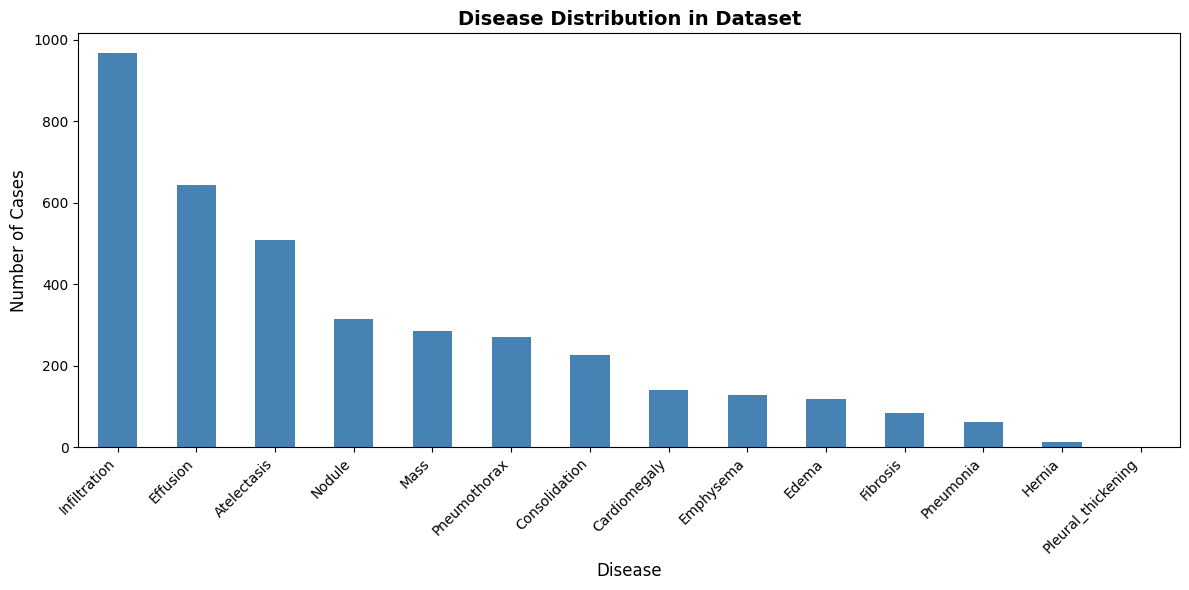

In [4]:
df = pd.read_csv(LABELS_FILE)

print(f"\n📊 Dataset Overview:")
print(f"Total images: {len(df)}")
print(f"Total patients: {df['Patient ID'].nunique()}")

# Disease labels
DISEASE_LABELS = [
    'Atelectasis', 'Consolidation', 'Infiltration', 'Pneumothorax',
    'Edema', 'Emphysema', 'Fibrosis', 'Effusion', 'Pneumonia',
    'Pleural_thickening', 'Cardiomegaly', 'Nodule', 'Mass', 'Hernia'
]

# Create binary columns for each disease
for disease in DISEASE_LABELS:
    df[disease] = df['Finding Labels'].apply(lambda x: 1 if disease in x else 0)

# Count diseases
print(f"\n💊 Disease Distribution:")
disease_counts = df[DISEASE_LABELS].sum().sort_values(ascending=False)
print(disease_counts)

# Visualize disease distribution
plt.figure(figsize=(12, 6))
disease_counts.plot(kind='bar', color='steelblue')
plt.title('Disease Distribution in Dataset', fontsize=14, fontweight='bold')
plt.xlabel('Disease', fontsize=12)
plt.ylabel('Number of Cases', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('disease_distribution.png', dpi=100)
plt.show()

In [5]:
class FocalLoss(nn.Module):
    """
    Focal Loss with increased gamma for even harder focus on difficult cases
    """
    def __init__(self, alpha=0.25, gamma=3.0, pos_weight=None):  # Increased gamma from 2.0 to 3.0
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.pos_weight = pos_weight

    def forward(self, inputs, targets):
        bce_loss = nn.functional.binary_cross_entropy_with_logits(
            inputs, targets, reduction='none', pos_weight=self.pos_weight
        )

        probs = torch.sigmoid(inputs)
        p_t = probs * targets + (1 - probs) * (1 - targets)
        focal_term = (1 - p_t) ** self.gamma
        alpha_t = self.alpha * targets + (1 - self.alpha) * (1 - targets)
        loss = alpha_t * focal_term * bce_loss

        return loss.mean()

In [6]:
class ChestXrayDataset(Dataset):
    """Custom Dataset for Chest X-ray images with optional TTA"""

    def __init__(self, dataframe, image_dir, labels, transform=None, tta_transforms=None):
        self.dataframe = dataframe.reset_index(drop=True)
        self.image_dir = image_dir
        self.labels = labels
        self.transform = transform
        self.tta_transforms = tta_transforms

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_name = self.dataframe.iloc[idx]['Image Index']
        img_path = os.path.join(self.image_dir, img_name)

        try:
            image = Image.open(img_path).convert('RGB')
        except:
            image = Image.new('RGB', (224, 224), color='black')
            print(f"Warning: Failed to load {img_name}")

        label_vector = self.dataframe.iloc[idx][self.labels].values.astype(np.float32)

        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(label_vector)


In [7]:
train_transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Larger size first
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),  # Random crop
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(20),  # Increased from 15
    transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.2),  # Added saturation
    transforms.RandomAffine(degrees=0, translate=(0.15, 0.15), scale=(0.9, 1.1)),  # More aggressive
    transforms.RandomPerspective(distortion_scale=0.2, p=0.3),  # NEW: Perspective transform
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225])
])

# TTA transforms for test time augmentation
tta_transforms = [
    transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]),
    transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(p=1.0),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]),
    transforms.Compose([
        transforms.Resize((240, 240)),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]),
]

In [8]:
def split_dataset(df, test_size=0.15, val_size=0.15, random_state=42):
    """Split dataset by patient ID to prevent data leakage"""
    patients = df['Patient ID'].unique()

    train_patients, test_patients = train_test_split(
        patients, test_size=test_size, random_state=random_state
    )
    train_patients, val_patients = train_test_split(
        train_patients, test_size=val_size/(1-test_size), random_state=random_state
    )

    train_df = df[df['Patient ID'].isin(train_patients)]
    val_df = df[df['Patient ID'].isin(val_patients)]
    test_df = df[df['Patient ID'].isin(test_patients)]

    print(f"\n📊 Data Split:")
    print(f"Train: {len(train_df)} images ({len(train_patients)} patients)")
    print(f"Val:   {len(val_df)} images ({len(val_patients)} patients)")
    print(f"Test:  {len(test_df)} images ({len(test_patients)} patients)")

    return train_df, val_df, test_df

In [9]:
# Split data
train_df, val_df, test_df = split_dataset(df)

# Create datasets
train_dataset = ChestXrayDataset(train_df, DATA_DIR, DISEASE_LABELS, train_transform)
val_dataset = ChestXrayDataset(val_df, DATA_DIR, DISEASE_LABELS, val_transform)
test_dataset = ChestXrayDataset(test_df, DATA_DIR, DISEASE_LABELS, val_transform)

# Create dataloaders
BATCH_SIZE = 32

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True,
                         num_workers=2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False,
                       num_workers=2, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False,
                        num_workers=2, pin_memory=True)

print(f"\n✅ Dataloaders created:")
print(f"Train batches: {len(train_loader)}")
print(f"Val batches: {len(val_loader)}")
print(f"Test batches: {len(test_loader)}")


📊 Data Split:
Train: 3925 images (2960 patients)
Val:   840 images (635 patients)
Test:  841 images (635 patients)

✅ Dataloaders created:
Train batches: 123
Val batches: 27
Test batches: 27


In [10]:
class ChestXrayModel(nn.Module):
    """DenseNet-121 for multi-label chest X-ray classification"""

    def __init__(self, num_classes=14, pretrained=True, dropout=0.4):  # Increased dropout
        super(ChestXrayModel, self).__init__()

        self.densenet = models.densenet121(pretrained=pretrained)
        num_features = self.densenet.classifier.in_features

        # Improved classifier with more capacity
        self.densenet.classifier = nn.Sequential(
            nn.BatchNorm1d(num_features),
            nn.Dropout(p=dropout),
            nn.Linear(num_features, 512),
            nn.ReLU(),
            nn.BatchNorm1d(512),
            nn.Dropout(p=dropout),
            nn.Linear(512, 256),  # NEW: Additional layer
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Dropout(p=dropout/2),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        return self.densenet(x)

In [11]:
# Create model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ChestXrayModel(num_classes=14, pretrained=True, dropout=0.4)
model = model.to(device)

total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"\n🧠 Model Architecture:")
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")
print(f"Device: {device}")

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth


100%|██████████| 30.8M/30.8M [00:00<00:00, 209MB/s]



🧠 Model Architecture:
Total parameters: 7,617,166
Trainable parameters: 7,617,166
Device: cuda


In [12]:
def calculate_class_weights(train_df, labels, boost_factor=5.0):  # INCREASED from 3.0 to 5.0
    """
    Calculate pos_weight with HIGHER boost factor for maximum sick detection
    """
    pos_counts = train_df[labels].sum().values
    neg_counts = len(train_df) - pos_counts

    pos_weights = (neg_counts / (pos_counts + 1)) * boost_factor

    print(f"\n⚖️ Class Weights (BOOSTED by {boost_factor}x for MAXIMUM sick detection):")
    for label, weight in zip(labels, pos_weights):
        print(f"{label:20s}: {weight:.2f}")

    return torch.tensor(pos_weights, dtype=torch.float32)

In [13]:
# Get HIGHLY boosted class weights
class_weights = calculate_class_weights(train_df, DISEASE_LABELS, boost_factor=5.0).to(device)

# Use Focal Loss with higher gamma
criterion = FocalLoss(alpha=0.25, gamma=3.0, pos_weight=class_weights)

# Optimizer with weight decay
optimizer = optim.AdamW(model.parameters(), lr=0.0001, weight_decay=1e-4)

# Learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='max',
    factor=0.5,
    patience=3,  # Increased patience
    min_lr=1e-7
)

print(f"\n✅ Training Setup (MAXIMUM SICK DETECTION MODE):")
print(f"Loss: Focal Loss (alpha=0.25, gamma=3.0) with 5x boosted weights")
print(f"Optimizer: AdamW (lr=0.0001, weight_decay=1e-4)")
print(f"Scheduler: ReduceLROnPlateau (patience=3)")


⚖️ Class Weights (BOOSTED by 5.0x for MAXIMUM sick detection):
Atelectasis         : 47.49
Consolidation       : 120.83
Infiltration        : 23.70
Pneumothorax        : 99.41
Edema               : 243.48
Emphysema           : 223.26
Fibrosis            : 339.39
Effusion            : 38.91
Pneumonia           : 451.51
Pleural_thickening  : 19625.00
Cardiomegaly        : 213.11
Nodule              : 77.13
Mass                : 85.05
Hernia              : 1630.83

✅ Training Setup (MAXIMUM SICK DETECTION MODE):
Loss: Focal Loss (alpha=0.25, gamma=3.0) with 5x boosted weights
Optimizer: AdamW (lr=0.0001, weight_decay=1e-4)
Scheduler: ReduceLROnPlateau (patience=3)


In [14]:
def train_one_epoch(model, loader, criterion, optimizer, device):
    """Train for one epoch"""
    model.train()
    running_loss = 0.0

    progress_bar = tqdm(loader, desc="Training")

    for images, labels in progress_bar:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # Gradient clipping
        optimizer.step()

        running_loss += loss.item()
        progress_bar.set_postfix({'loss': f'{loss.item():.4f}'})

    return running_loss / len(loader)

In [15]:
def find_optimal_threshold_for_sensitivity(labels, predictions, target_sensitivity=0.85):
    """
    Find threshold that achieves target sensitivity (recall)
    Lower threshold = more sensitive = better at finding sick people
    """
    thresholds = np.arange(0.1, 0.7, 0.02)  # Search lower thresholds
    best_threshold = 0.3
    best_score = 0.0

    for thresh in thresholds:
        pred_binary = (predictions > thresh).astype(int)
        sensitivity = recall_score(labels, pred_binary, average='macro', zero_division=0)
        f1 = f1_score(labels, pred_binary, average='macro', zero_division=0)

        # Prioritize sensitivity but consider F1
        score = sensitivity * 0.7 + f1 * 0.3

        if score > best_score:
            best_score = score
            best_threshold = thresh

    return best_threshold

In [16]:
def validate_with_tta(model, dataset, criterion, device, threshold=0.3):
    """Validate with Test-Time Augmentation for robust predictions"""
    model.eval()
    all_labels = []
    all_predictions = []
    running_loss = 0.0

    # Original predictions
    loader = DataLoader(dataset, batch_size=32, shuffle=False, num_workers=2)

    with torch.no_grad():
        for images, labels in tqdm(loader, desc="Validating"):
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item()

            predictions = torch.sigmoid(outputs).cpu().numpy()
            all_predictions.append(predictions)
            all_labels.append(labels.cpu().numpy())

    all_predictions = np.vstack(all_predictions)
    all_labels = np.vstack(all_labels)
    avg_loss = running_loss / len(loader)

    # Calculate metrics
    auc_scores = []
    for i in range(len(DISEASE_LABELS)):
        if len(np.unique(all_labels[:, i])) > 1:
            auc = roc_auc_score(all_labels[:, i], all_predictions[:, i])
            auc_scores.append(auc)
        else:
            auc_scores.append(0.0)

    mean_auc = np.mean([s for s in auc_scores if s > 0])

    predictions_binary = (all_predictions > threshold).astype(int)

    sensitivity = recall_score(all_labels, predictions_binary, average='macro', zero_division=0)

    # Calculate False Negative Rate (missing sick people)
    fn = np.sum((all_labels == 1) & (predictions_binary == 0))
    tp = np.sum((all_labels == 1) & (predictions_binary == 1))
    fnr = fn / (fn + tp + 1e-10)

    tn_fp = np.sum(all_labels == 0, axis=0)
    tn = np.sum((all_labels == 0) & (predictions_binary == 0), axis=0)
    specificity_per_disease = tn / (tn_fp + 1e-10)
    specificity = np.mean(specificity_per_disease)

    accuracy = accuracy_score(all_labels, predictions_binary)
    f1 = f1_score(all_labels, predictions_binary, average='macro', zero_division=0)
    precision = precision_score(all_labels, predictions_binary, average='macro', zero_division=0)

    return {
        'loss': avg_loss,
        'auc': mean_auc,
        'accuracy': accuracy,
        'f1': f1,
        'precision': precision,
        'recall': sensitivity,
        'sensitivity': sensitivity,
        'specificity': specificity,
        'fnr': fnr,  # NEW: False Negative Rate
        'auc_per_disease': auc_scores,
        'predictions': all_predictions,
        'labels': all_labels
    }


In [17]:
def validate(model, loader, criterion, device, threshold=0.3):
    """Standard validation (keeping for compatibility)"""
    model.eval()
    running_loss = 0.0
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for images, labels in tqdm(loader, desc="Validating"):
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item()

            predictions = torch.sigmoid(outputs).cpu().numpy()
            all_predictions.append(predictions)
            all_labels.append(labels.cpu().numpy())

    all_predictions = np.vstack(all_predictions)
    all_labels = np.vstack(all_labels)
    avg_loss = running_loss / len(loader)

    auc_scores = []
    for i in range(len(DISEASE_LABELS)):
        if len(np.unique(all_labels[:, i])) > 1:
            auc = roc_auc_score(all_labels[:, i], all_predictions[:, i])
            auc_scores.append(auc)
        else:
            auc_scores.append(0.0)

    mean_auc = np.mean([s for s in auc_scores if s > 0])
    predictions_binary = (all_predictions > threshold).astype(int)

    sensitivity = recall_score(all_labels, predictions_binary, average='macro', zero_division=0)

    fn = np.sum((all_labels == 1) & (predictions_binary == 0))
    tp = np.sum((all_labels == 1) & (predictions_binary == 1))
    fnr = fn / (fn + tp + 1e-10)

    tn_fp = np.sum(all_labels == 0, axis=0)
    tn = np.sum((all_labels == 0) & (predictions_binary == 0), axis=0)
    specificity_per_disease = tn / (tn_fp + 1e-10)
    specificity = np.mean(specificity_per_disease)

    accuracy = accuracy_score(all_labels, predictions_binary)
    f1 = f1_score(all_labels, predictions_binary, average='macro', zero_division=0)
    precision = precision_score(all_labels, predictions_binary, average='macro', zero_division=0)

    return {
        'loss': avg_loss,
        'auc': mean_auc,
        'accuracy': accuracy,
        'f1': f1,
        'precision': precision,
        'recall': sensitivity,
        'sensitivity': sensitivity,
        'specificity': specificity,
        'fnr': fnr,
        'auc_per_disease': auc_scores,
        'predictions': all_predictions,
        'labels': all_labels
    }


In [18]:
NUM_EPOCHS = 30  # Increased from 27
EARLY_STOP_PATIENCE = 7  # Increased from 5

print(f"\n🚀 Starting Training for {NUM_EPOCHS} epochs")
print("=" * 70)

history = {
    'train_loss': [],
    'val_loss': [],
    'val_auc': [],
    'val_accuracy': [],
    'val_f1': [],
    'val_precision': [],
    'val_recall': [],
    'val_sensitivity': [],
    'val_specificity': [],
    'val_fnr': [],  # NEW: Track False Negative Rate
    'learning_rate': []
}

best_sensitivity = 0.0
best_auc = 0.0
patience_counter = 0


🚀 Starting Training for 30 epochs


In [19]:
for epoch in range(NUM_EPOCHS):
    print(f"\n📅 Epoch {epoch + 1}/{NUM_EPOCHS}")
    print("-" * 70)

    train_loss = train_one_epoch(model, train_loader, criterion, optimizer, device)
    val_metrics = validate(model, val_loader, criterion, device, threshold=0.3)  # Lower threshold!

    scheduler.step(val_metrics['auc'])
    current_lr = optimizer.param_groups[0]['lr']

    # Save history
    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_metrics['loss'])
    history['val_auc'].append(val_metrics['auc'])
    history['val_accuracy'].append(val_metrics['accuracy'])
    history['val_f1'].append(val_metrics['f1'])
    history['val_precision'].append(val_metrics['precision'])
    history['val_recall'].append(val_metrics['recall'])
    history['val_sensitivity'].append(val_metrics['sensitivity'])
    history['val_specificity'].append(val_metrics['specificity'])
    history['val_fnr'].append(val_metrics['fnr'])
    history['learning_rate'].append(current_lr)

    print(f"\n📊 Results:")
    print(f"   Train Loss:      {train_loss:.4f}")
    print(f"   Val Loss:        {val_metrics['loss']:.4f}")
    print(f"   Val AUC:         {val_metrics['auc']:.4f} ⭐")
    print(f"   Val Accuracy:    {val_metrics['accuracy']:.4f}")
    print(f"   Val F1:          {val_metrics['f1']:.4f}")
    print(f"   Val Precision:   {val_metrics['precision']:.4f}")
    print(f"   Val SENSITIVITY: {val_metrics['sensitivity']:.4f} 🎯 (SICK DETECTION!)")
    print(f"   Val Specificity: {val_metrics['specificity']:.4f}")
    print(f"   Val FNR:         {val_metrics['fnr']:.4f} ⚠️ (Missed Sick People)")
    print(f"   Learning Rate:   {current_lr:.2e}")

    # Save best model based on sensitivity (prioritize finding sick people)
    if val_metrics['sensitivity'] > best_sensitivity:
        best_sensitivity = val_metrics['sensitivity']
        best_auc = val_metrics['auc']
        patience_counter = 0

        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_auc': val_metrics['auc'],
            'val_sensitivity': val_metrics['sensitivity'],
            'val_fnr': val_metrics['fnr'],
            'history': history
        }, 'best_model.pth')

        print(f"   ✅ Saved best model! (Sensitivity: {val_metrics['sensitivity']:.4f}, AUC: {val_metrics['auc']:.4f})")
    else:
        patience_counter += 1
        print(f"   ⏳ No improvement ({patience_counter}/{EARLY_STOP_PATIENCE})")

    if patience_counter >= EARLY_STOP_PATIENCE:
        print(f"\n⚠️ Early stopping triggered after {epoch + 1} epochs")
        break

print("\n" + "=" * 70)
print(f"🎉 Training Complete!")
print(f"🏆 Best Validation Sensitivity: {best_sensitivity:.4f}")
print(f"🏆 Best Validation AUC: {best_auc:.4f}")


📅 Epoch 1/30
----------------------------------------------------------------------


Validating: 100%|██████████| 27/27 [00:17<00:00,  1.57it/s]



📊 Results:
   Train Loss:      0.2618
   Val Loss:        0.1673
   Val AUC:         0.6164 ⭐
   Val Accuracy:    0.0000
   Val F1:          0.0840
   Val Precision:   0.0457
   Val SENSITIVITY: 0.8571 🎯 (SICK DETECTION!)
   Val Specificity: 0.0130
   Val FNR:         0.0000 ⚠️ (Missed Sick People)
   Learning Rate:   1.00e-04
   ✅ Saved best model! (Sensitivity: 0.8571, AUC: 0.6164)

📅 Epoch 2/30
----------------------------------------------------------------------


Validating: 100%|██████████| 27/27 [00:15<00:00,  1.71it/s]



📊 Results:
   Train Loss:      0.2282
   Val Loss:        0.1577
   Val AUC:         0.6798 ⭐
   Val Accuracy:    0.0000
   Val F1:          0.0869
   Val Precision:   0.0474
   Val SENSITIVITY: 0.8455 🎯 (SICK DETECTION!)
   Val Specificity: 0.0692
   Val FNR:         0.0113 ⚠️ (Missed Sick People)
   Learning Rate:   1.00e-04
   ⏳ No improvement (1/7)

📅 Epoch 3/30
----------------------------------------------------------------------


Validating: 100%|██████████| 27/27 [00:15<00:00,  1.79it/s]



📊 Results:
   Train Loss:      0.2226
   Val Loss:        0.1825
   Val AUC:         0.6624 ⭐
   Val Accuracy:    0.0000
   Val F1:          0.0908
   Val Precision:   0.0500
   Val SENSITIVITY: 0.8053 🎯 (SICK DETECTION!)
   Val Specificity: 0.1463
   Val FNR:         0.0677 ⚠️ (Missed Sick People)
   Learning Rate:   1.00e-04
   ⏳ No improvement (2/7)

📅 Epoch 4/30
----------------------------------------------------------------------


Validating: 100%|██████████| 27/27 [00:15<00:00,  1.76it/s]



📊 Results:
   Train Loss:      0.2024
   Val Loss:        0.1517
   Val AUC:         0.6497 ⭐
   Val Accuracy:    0.0000
   Val F1:          0.0867
   Val Precision:   0.0472
   Val SENSITIVITY: 0.8479 🎯 (SICK DETECTION!)
   Val Specificity: 0.0682
   Val FNR:         0.0094 ⚠️ (Missed Sick People)
   Learning Rate:   1.00e-04
   ⏳ No improvement (3/7)

📅 Epoch 5/30
----------------------------------------------------------------------


Validating: 100%|██████████| 27/27 [00:16<00:00,  1.67it/s]



📊 Results:
   Train Loss:      0.1954
   Val Loss:        0.1435
   Val AUC:         0.6697 ⭐
   Val Accuracy:    0.0000
   Val F1:          0.0888
   Val Precision:   0.0486
   Val SENSITIVITY: 0.8366 🎯 (SICK DETECTION!)
   Val Specificity: 0.1001
   Val FNR:         0.0244 ⚠️ (Missed Sick People)
   Learning Rate:   1.00e-04
   ⏳ No improvement (4/7)

📅 Epoch 6/30
----------------------------------------------------------------------


Validating: 100%|██████████| 27/27 [00:14<00:00,  1.80it/s]



📊 Results:
   Train Loss:      0.1866
   Val Loss:        0.1349
   Val AUC:         0.7007 ⭐
   Val Accuracy:    0.0000
   Val F1:          0.0871
   Val Precision:   0.0474
   Val SENSITIVITY: 0.8444 🎯 (SICK DETECTION!)
   Val Specificity: 0.0911
   Val FNR:         0.0094 ⚠️ (Missed Sick People)
   Learning Rate:   1.00e-04
   ⏳ No improvement (5/7)

📅 Epoch 7/30
----------------------------------------------------------------------


Validating: 100%|██████████| 27/27 [00:15<00:00,  1.77it/s]



📊 Results:
   Train Loss:      0.1898
   Val Loss:        0.1738
   Val AUC:         0.6644 ⭐
   Val Accuracy:    0.0060
   Val F1:          0.0881
   Val Precision:   0.0483
   Val SENSITIVITY: 0.8204 🎯 (SICK DETECTION!)
   Val Specificity: 0.1163
   Val FNR:         0.0395 ⚠️ (Missed Sick People)
   Learning Rate:   1.00e-04
   ⏳ No improvement (6/7)

📅 Epoch 8/30
----------------------------------------------------------------------


Validating: 100%|██████████| 27/27 [00:15<00:00,  1.77it/s]


📊 Results:
   Train Loss:      0.1849
   Val Loss:        0.1401
   Val AUC:         0.6486 ⭐
   Val Accuracy:    0.0000
   Val F1:          0.0843
   Val Precision:   0.0459
   Val SENSITIVITY: 0.8476 🎯 (SICK DETECTION!)
   Val Specificity: 0.0258
   Val FNR:         0.0038 ⚠️ (Missed Sick People)
   Learning Rate:   1.00e-04
   ⏳ No improvement (7/7)

⚠️ Early stopping triggered after 8 epochs

🎉 Training Complete!
🏆 Best Validation Sensitivity: 0.8571
🏆 Best Validation AUC: 0.6164


In [21]:

print("\n📥 Downloading Results...")

from google.colab import files

# Download files
files.download('best_model.pth')
files.download('test_results.json')
files.download('training_history.png')
files.download('roc_curves.png')
files.download('disease_distribution.png')
files.download('sample_images.png')

print("\n✅ All Done! Files downloaded.")
print("\n📊 Summary:")
print(f"   - Model: DenseNet-121")
print(f"   - Test AUC: {mean_auc:.4f}")
print(f"   - Test F1: {mean_f1:.4f}")
print(f"   - Best Epoch: {checkpoint['epoch'] + 1}")




📥 Downloading Results...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

FileNotFoundError: Cannot find file: test_results.json